# Reinforcement Learning for Lux AI Season 2 🤖

Part 2 of the RL series will now dig into building a working RL agent for the Lux AI Challenge, Season 2!

Lux AI is designed to be intuitive to understand, but heavily layered in complexity and interactions of game mechanics in an multi-agent cooperative and competitive environment. 

Lux AI Season 2's rules can be found here: https://www.lux-ai.org/specs-s2. Make sure to read them to learn how to the game works, and the rest of this tutorial will be easier to understand.

Part 1 of the series covered the single-agent RL setup, but Lux AI Season 2 is multi-agent! Moreover, the environment has different phases and a complex action space which makes it difficult to learn or use of the box. 

This tutorial will cover simple tools and tricks on how to reduce a complex problem into a easier one! We will primarily focus on three things: 

1. Transforming the three phase Lux AI game into a single phase game
2. Simplifying observations
3. Simplifying the action space with controllers/action wrappers


## TODO

Normally RL frameworks like Stable Baselines 3, RLlib, Tianshou etc. expect the action space and observation space to be consistent throughout an episode. Lux S2 does not conform to this as we add some additional complexity like bidding and factory placement phases. A simple way to get around this is to **upgrade the reset function.**

Previously we saw that `env.reset()` resets an environment to a clean slate. We will upgrade this function by building a environment wrapper that not only resets to the clean slate, but also handles the bidding and factory placement phases so effectively agents that are learning start from game states with factories already placed.

Lets start coding! To do this, we will use what's known as a [Wrapper](https://www.gymlibrary.dev/api/wrappers/), which allows us to flexibly transform the inputs, outputs, and behavior of a given environment. We will build one that works with the SB3 package. To do this, we want to provide the wrapper a bidding policy and factory placement policy which will be used by all teams to handle the first two phases in the reset function. The code below does just that by overriding the environment's reset function in the wrapper. We also provide a number of useful typings. See the comments in the code to understand each line step by step.

In [34]:
import gym
from luxai_s2 import LuxAI_S2
from luxai_s2.utils import my_turn_to_place_factory
import numpy as np
# below imports some typings
from luxai_s2.state import ObservationStateDict
from luxai_s2.unit import ActionType, BidActionType, FactoryPlacementActionType
from typing import Callable, Dict

class SB3Wrapper(gym.Wrapper):
    def __init__(
        self, 
        env: LuxAI_S2,
        bid_policy: Callable[[str, ObservationStateDict], Dict[str, BidActionType]] = None,
        factory_placement_policy: Callable[[str, ObservationStateDict], Dict[str, FactoryPlacementActionType]] = None
    ) -> None:
        super().__init__(env)
        self.factory_placement_policy = factory_placement_policy
        self.bid_policy = bid_policy

    # override the original reset function
    def reset(self, **kwargs):
        # call the original LuxAI_s2 environment's reset function first
        obs = self.env.reset(**kwargs)
        
        # we upgrade the reset function by stepping through the environment and handling the bidding
        # and factory placement phase until we enter the normal game phase
        
        # For each agent, we generate a bid action using our bid policy
        action = dict()
        for agent in self.agents:
            action[agent] = self.bid_policy(agent, obs[agent])
        obs, _, _, _ = self.env.step(action)
        
        # During the factory placement phase, for each agent we
        # generate a factory placement action using the previously given policy
        while self.env.state.real_env_steps < 0:
            action = dict()
            for agent in self.agents:
                if my_turn_to_place_factory(
                    obs["player_0"]["teams"][agent]["place_first"],
                    self.env.state.env_steps,
                ):
                    action[agent] = self.factory_placement_policy(agent, obs[agent])
                else:
                    action[agent] = dict()
            obs, _, _, _ = self.env.step(action)
        self.prev_obs = obs
        # by here, the environment has `real_env_steps == 0` which means we are in the normal game phase
        # the returned observation and future accepted actions will be for the normal game phase
        return obs

To test the code above, we can program some heuristic bid and factory placement policies

In [35]:
def zero_bid(player, obs: ObservationStateDict) -> BidActionType:
    # a policy that always bids 0
    faction = "AlphaStrike"
    if player == "player_1":
        faction = "MotherMars"
    return dict(bid=0, faction=faction)

def random_factory_placement(player, obs: ObservationStateDict) -> FactoryPlacementActionType:
    """
    This policy places factories with 150 water and metal at random locations
    """
    # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
    potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
    spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
    return dict(spawn=spawn_loc, metal=150, water=150)

So **without the wrapper**, when we reset the environment it looks like this:

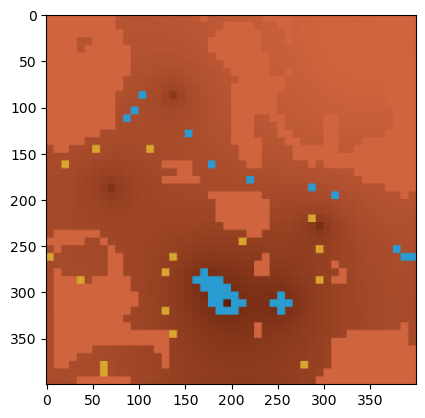

In [39]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

**With the wrapper**, when we reset the environment it looks like this:

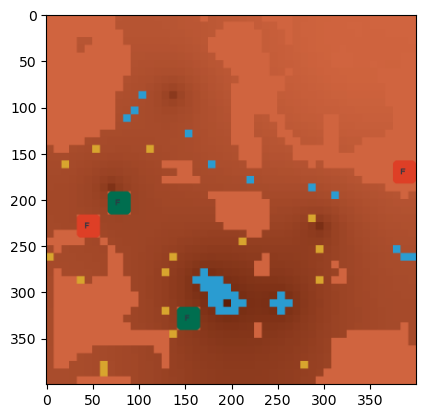

In [40]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env = SB3Wrapper(env, zero_bid, random_factory_placement)
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

Success! Our upgraded reset function makes the environment now start from the start of the normal game phase, meaning the action space can be consistently the same throughout the game.

## Simplifying the Action Space

The action space is quite complicated in Lux S2 as each robot can move, dig, transfer/pickup, all in addition to being able to combine any sequence of these primitives into an action queue of up to length 20. For machine learning, such a massive action space leads to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), making any ML algorithm have a much harder time to learn something useful, especially in RL.

To handle this, we can program a custom Controller that translates actions from one action space to the original action space. For the sake of brevity, we will use an existing controller that can be imported from the `luxai_s2.wrappers.controllers` package called [`SimpleUnitDiscreteController`](https://github.com/Lux-AI-Challenge/Lux-Design-S2/blob/main/luxai_s2/luxai_s2/wrappers/controllers.py) which extends the general `Controller` class. This controller allows control to `max_robots` number of robots in an episode and assumes you only ever have that many robots on the field in any game. 

This controller also removes a number of actions and only keeps 4 directional movement, transferring ice, picking up resources, digging, and a no-op action. This doesn't include factory actions, self destruct, recharging, transferring other types of resources, or longer planned action queues in the action space, which are all open problems for you to potentially tackle!

Finally, the controller also includes a trick to allow agents to reduce power costs incurred by action queue updates. The controller skips updating action queues if the existing action queue is the same as the new one the agent wants to use for the robot.

For fast training, we use `max_robots=1` and learn to control just a single robot that is spawned in this tutorial. 

More advanced usages can consider how to model the actions of many units on a game board by using a MultiDiscrete action space and setting `max_robots > 1`. A more practical and likely winning solution can be to use a image-like controller by generating actions for each tile on the board and only using the actions with friendly units on that tile. See [Season 1's solution by ToadBrigade](https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) and our previous [research paper: Emergent Collective Intelligence from Massive-Agent Cooperation and Competition](https://arxiv.org/abs/2301.01609) for how a image-like controller can work.


In [43]:
from luxai_s2.wrappers.controllers import SimpleUnitDiscreteController, Controller

ImportError: cannot import name 'SimpleUnitDiscreteController' from 'luxai_s2.wrappers.controllers' (/Users/stonetao/Desktop/Coding/Projects/aicompetitions/LuxAI/Lux-Design-2022/luxai_s2/luxai_s2/wrappers/controllers.py)

## Simplifying the Observation Space

Lux S2 is fully observable which means you can see everything on the map, the opponents units etc. However, this is very high dimensional and not necessarily easy to learn from due to the curse of dimensionality (again!). We want to simplify this observation space in a way that contains sufficient information to learn a good policy but is also easy to learn from.

For this tutorial, we will create a state-based observation space (no image like features e.g. the rubble, ice, ore maps) with some feature engineering that includes useful information such as the distance to the closest factory and ice tile. We provide one that works in tandem with the `SimpleUnitDiscreteController` called [`SimpleUnitObservationWrapper`](https://github.com/Lux-AI-Challenge/Lux-Design-S2/blob/main/luxai_s2/luxai_s2/wrappers/obs_wrappers.py).


More advanced solutions can look into using the full set of observations and designing the appropriate neural net architecture to process them. One idea would be to use convolutional neural networks to process board features like images. See [Season 1's solution by ToadBrigade](https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) and our previous [research paper: Emergent Collective Intelligence from Massive-Agent Cooperation and Competition](https://arxiv.org/abs/2301.01609) for example architectures and feature engineering choices.


In [ ]:
from luxai_s2.wrappers.obs_wrappers import SimpleUnitObservationWrapper

## Training

In the previous tutorial, we saw how to train an agent with SB3 in single-agent environments. Handling true multi-agent via training separate or shared policies to control all agents requires a few extra things so instead, for the purpose of a tutorial we will treat Lux S2 like a single agent environment by training a policy for one team and letting the other team simply do nothing.

Moreover, we want to define our own reward function to encourage our robots to seek ice, dig it, and return to a factory so it can generate water and survive longer.




## Multi-agent to Single-agent

Multi-agent environments are effectively multiple singular agents put together in the same environment at the same time. In typical multi-agent RL, you may often want to train a policy that plays all the controllable agents, not just one, which gathers more replay data and enables self-play. Self-play is a future topic to be discussed but shows potential to autonomously train a policy against itself and lead to learning stronger and stronger behaviors and potentially even emergent ones.

For the sake of a tutorial, we will treat Lux as a single-agent environment. Naturally, a way to reduce the problem is to simply control only one of the agents in the game and let the other agent be a agent that does nothing or a heuristic of some kind to train against.